In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


# import data

In [4]:
df = pd.read_csv('../raw_data/time_series/monthly_champagne_sales.csv')
df

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [5]:
# datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index(df['Month'],inplace=True)
df.drop(columns='Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


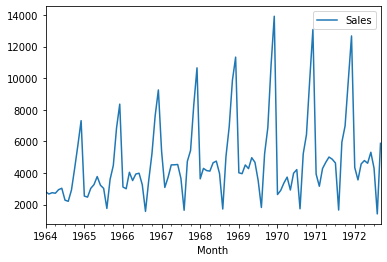

In [6]:
# visualize
df.plot();
# not stationary,obvious seasonality,has a trend

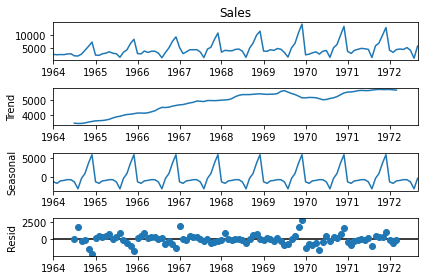

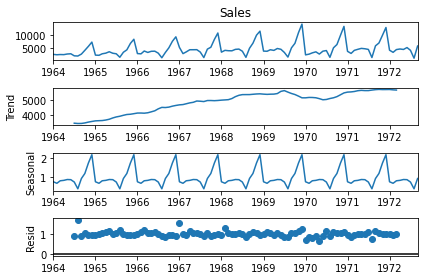

In [10]:
# decomposition

result_add = seasonal_decompose(df['Sales'],model='additive')
result_add.plot();

result_mul = seasonal_decompose(df['Sales'], model='multiplicative')
result_mul.plot();

In [11]:
df['deseasonalized_Sales'] = df.Sales.values/result_mul.seasonal
df.head()

,Sales,deseasonalized_Sales
Month,,
1964-01-01,2815,3730.319180
1964-02-01,2672,3963.074857
1964-03-01,2755,3410.982407
1964-04-01,2721,3278.506326
1964-05-01,2946,3369.558356


# build model

## stationary

In [12]:
# split data
df_train = df[:'1969-12-01'].Sales
df_test = df['1970-01-01':].Sales

In [14]:
# check stationary
adfuller(df['Sales'])[1] 

0.3639157716602437

In [22]:
# seasonal differencing of lag 12
diff = df['Sales'].diff(12).dropna()

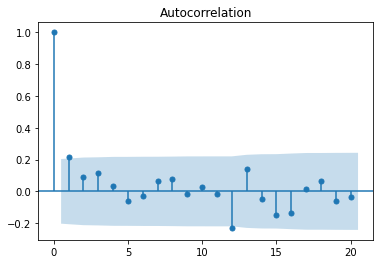

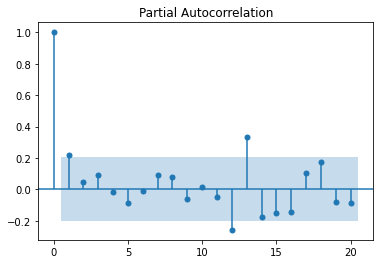

In [23]:
plot_acf(diff);
plot_pacf(diff);

In [24]:
D = 1
m = 12
d = 0

## arima grid search

In [26]:
model = pm.auto_arima(df_train,m=12,D=1,d=0,
                       start_p=0, max_p=2,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_Q=0, max_Q=2,
                       seasonal=True,n_jobs=-1,
                       trace=True,error_action='ignore',suppress_warnings=True)

/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.10 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.589 seconds


## plot forecast

In [33]:
pred = model.predict(len(df_test),return_conf_int=True)
central = pd.Series(pred[0],index=df_test.index)
lower = pd.Series(pred[1][:,0],index = df_test.index)
upper = pd.Series(pred[1][:,1],index = df_test.index)

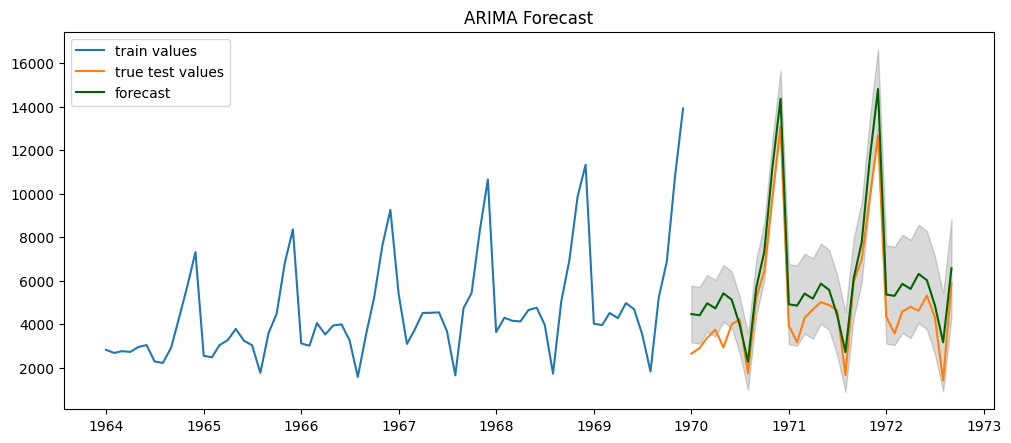

In [34]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("ARIMA Forecast")
plt.legend()
plt.show()

## Sarima Model 

In [30]:
sarima = SARIMAX(df_train,order=(1,1,1),seasonal_order=(1,1,1,12))
results = sarima.fit().get_forecast(len(df_test), alpha=0.05)
central = pd.Series(results.predicted_mean,index = df_test.index)
lower = pd.Series(results.conf_int()['lower Sales'],index = df_test.index)
upper = pd.Series(results.conf_int()['upper Sales'],index = df_test.index)

/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66952D+00    |proj g|=  2.15353D-01

At iterate    5    f=  6.57381D+00    |proj g|=  2.13065D-02

At iterate   10    f=  6.55545D+00    |proj g|=  6.58852D-03

At iterate   15    f=  6.55318D+00    |proj g|=  6.90635D-04

At iterate   20    f=  6.55282D+00    |proj g|=  1.35617D-03

At iterate   25    f=  6.55055D+00    |proj g|=  2.32426D-02

At iterate   30    f=  6.53699D+00    |proj g|=  7.24703D-03

At iterate   35    f=  6.53570D+00    |proj g|=  2.23419D-03

At iterate   40    f=  6.53042D+00    |proj g|=  2.09991D-02

At iterate   45    f=  6.52925D+00    |proj g|=  3.54279D-04

At iterate   50    f=  6.52920D+00    |proj g|=  2.84232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


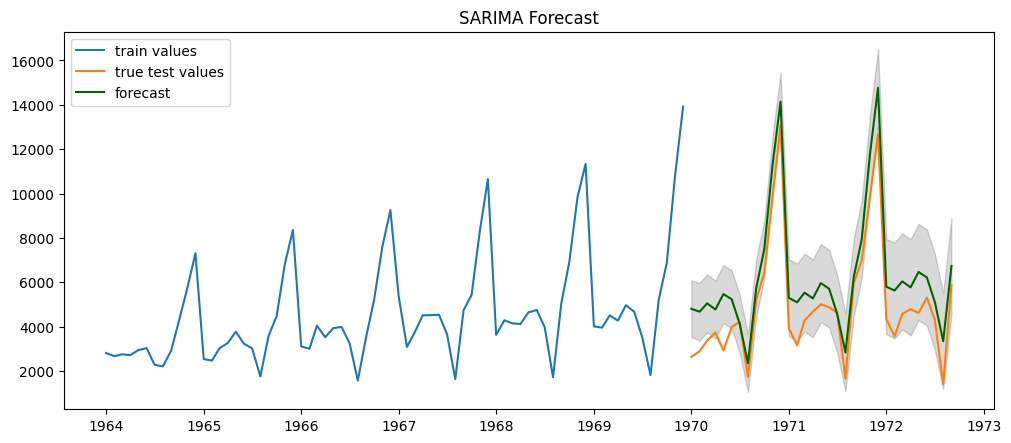

In [31]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

# forecast in another ML way

## preprocess data

In [35]:
df2 = df.copy()
for i in range(1,13):
    df2[f'x_{i}'] = df['Sales'].shift(i)

In [36]:
df2 = df2.dropna()

df2_train = df2[:'1969']
df2_test = df2['1970':]

In [37]:
test_indexes = np.arange(len(df2_train),len(df2_train)+len(df2_test))
test_indexes

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

In [38]:
X = df2.drop(columns = ['Sales'])
y = df2['Sales']

## build model

In [40]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=0)

## evaluate model 

In [42]:
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [43]:
results = evaluate_performance_month_prediction(y_true=y.values, 
                                                test_indexes=test_indexes,
                                                predictor=random_forest, 
                                                full_X = X.values)



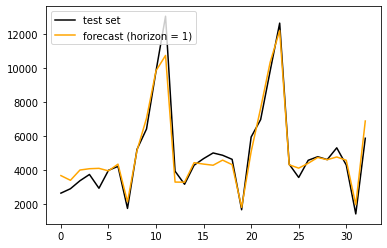

In [44]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

In [45]:
# Extract the trend using a well chosen moving average
df2['ma_12'] = df2['Sales'].rolling(window=12).mean()
df2['ma_3'] = df2['Sales'].rolling(window=3).mean()
df2['ma_2'] = df2['Sales'].rolling(window=2).mean()

<AxesSubplot:xlabel='Month'>

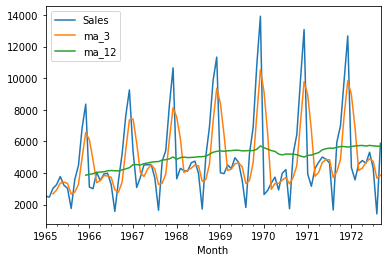

In [46]:
df2[["Sales","ma_3", "ma_12"]].plot()

In [47]:
# add a more smoothing predictor using the exponential moving average 
#(hint: method `.ewm` with `halflife` of 2, 3 and 12)

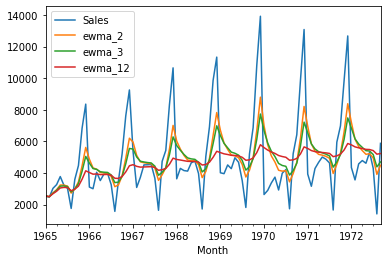

In [48]:
df2["ewma_2"] = df2["Sales"].ewm(halflife=2).mean()
df2["ewma_3"] = df2["Sales"].ewm(halflife=3).mean()
df2["ewma_12"] = df2["Sales"].ewm(halflife=12).mean()
df2[["Sales", "ewma_2", "ewma_3", "ewma_12"]].plot();

In [49]:
# fine tune model

random_forest = RandomForestRegressor(n_estimators=20, random_state=12)
features = ["ewma_2", "ewma_3", "ewma_12", "ma_2", "ma_3", "ma_12", "x_1","x_2","x_3","x_4","x_5",
                   "x_6","x_7","x_8","x_9","x_10","x_11","x_12"]
new_features = df2[features].fillna(0).values

results = evaluate_performance_month_prediction(df2["Sales"].values, 
                                                test_indexes=test_indexes,
                                                predictor=random_forest, 
                                                full_X = new_features)



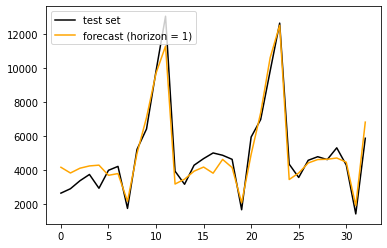

In [50]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend();

In [51]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, features)).sort_values(by=0, ascending=False)

,0,1
17,0.821873,x_12
3,0.062603,ma_2
7,0.020262,x_2
16,0.017454,x_11
1,0.014037,ewma_3
4,0.010594,ma_3
8,0.008481,x_3
15,0.007970,x_10
2,0.006503,ewma_12
11,0.005091,x_6
